<a href="https://colab.research.google.com/github/PhilHippo/MINDFUL-A-Lenskit-based-Recommender-System/blob/main/recsys_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [3]:
news = pd.read_csv('./training data/news.tsv',header=None,sep='\t')

In [4]:
news.columns=['News ID',
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities",
"Abstract Entities "]

print(news.shape)

(51282, 8)


In [10]:
c = news[['Category','SubCategory']].value_counts()

In [11]:
index=[]
for i in c.index:
    index.append(np.array(i))
index=np.array(index)

In [12]:
news_df=pd.DataFrame(columns = ['Category','Sub Category','Values'])
news_df['Category'] = index[:,0]
news_df['Sub Category'] = index[:,1]
news_df['Values'] = c.values

In [13]:
px.bar(data_frame=news_df,x='Category',y='Values',color='Sub Category')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


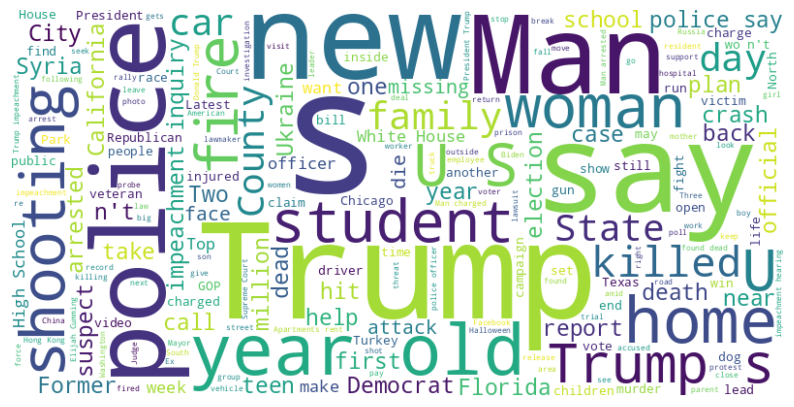

In [14]:
text=' '
for i in news[news['Category']=='news']['Title']:
    text += i + ' '

# Make the figure
nltk.download('punkt')
nltk.download('stopwords')


words = nltk.word_tokenize(text)
stop_words = set(stopwords.words('english'))
words = [word for word in words if word.lower() not in stop_words]

text = ' '.join(words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

In [22]:
# Load data
behaviors = pd.read_csv('./training data/behaviors.tsv', delimiter='\t', header=None)
news = pd.read_csv('./training data/news.tsv', delimiter='\t', header=None)

# Naming columns
behaviors.columns = ["impression_id", "user_id", "time", "history", "impressions"]
news.columns = ["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"]

# Remove NaN values in the 'abstract' column
news = news.dropna(subset=['abstract'])

# Extracting clicked news from behaviors, this is a column of lists of the clicked news (tagget with 1) for each impression
behaviors['clicked_news'] = behaviors['impressions'].apply(lambda x: [imp.split('-')[0] for imp in x.split() if imp.split('-')[1] == '1'])

# Flattening the clicked news and associating with user_id, that means we divide the lists into one row for each clicked news
clicked_news = behaviors.explode('clicked_news')[['user_id', 'clicked_news']].dropna()

# Remove clicked news that were removed from the news DataFrame
valid_news_ids = set(news['news_id'])
# Remove clicked news that were removed from the news DataFrame
valid_news_ids = set(news['news_id'])
clicked_news = clicked_news[clicked_news['clicked_news'].isin(valid_news_ids)].copy()

# Encoding user_id and news_id as categorical variables for memory and computation efficiency
clicked_news['user_id'] = clicked_news['user_id'].astype("category")
clicked_news['clicked_news'] = clicked_news['clicked_news'].astype("category")

print(f"Total number of news items: {news.shape[0]}") #48616 unique news
print(f"Number of unique clicked news: {clicked_news['clicked_news'].nunique()}") #7307 unique news have been clicked
print(f"Number of unique users: {clicked_news['user_id'].nunique()}")

(236344, 2)
Total number of news items: 48616
Number of unique clicked news: 7307
Number of unique users: 49445


In [4]:
# Load Universal Sentence Encoder (pretrained model)
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [5]:
# Embed the abstracts (takes a while)
news['abstract_embedding'] = news['abstract'].apply(lambda x: embed([x]).numpy().flatten())

In [6]:
# Compute content similarity matrix (takes up too much RAM)
abstract_embeddings = np.vstack(news['abstract_embedding'])
content_similarity_matrix = cosine_similarity(abstract_embeddings)

In [38]:
print(content_similarity_matrix.shape)

(48616, 48616)


In [9]:
#Here we make a user-item interaction matrix
# Creating a sparse matrix, this is only composed by positive interactions (all ones) since we'll use KNN and it's way faster
#(i, j) i is the item index in rows, j is the user index in columns
interaction_matrix = csr_matrix(
    (
        np.ones(clicked_news.shape[0]),
        (
            clicked_news['clicked_news'].cat.codes.copy(),
            clicked_news['user_id'].cat.codes.copy()
        )
    )
)

print(interaction_matrix.shape)

(7307, 49445)


In [8]:
# Ensure we're working with unique user and item IDs
unique_users = clicked_news['user_id'].drop_duplicates().reset_index(drop=True)
unique_items = clicked_news['clicked_news'].drop_duplicates().reset_index(drop=True)

# Create mappings from IDs to indices
user_to_idx = pd.Series(data=np.arange(len(unique_users)), index=unique_users)
item_to_idx = pd.Series(data=np.arange(len(unique_items)), index=unique_items)

# Create mappings from indices to IDs
idx_to_user = pd.Series(data=unique_users, index=np.arange(len(unique_users)))
idx_to_item = pd.Series(data=unique_items, index=np.arange(len(unique_items)))

In [9]:
# Compute Item Similarity using k-Nearest Neighbors
# Initialize the model, we choose cosine similarity due to the high dimensionality and sparsity of user interactions
# tipically a user interacts only with a small fraction of the news

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# Fit the model

model_knn.fit(interaction_matrix)  # .T transposes the matrix, as we want to find similar items, not users

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [ ]:
def recommend(user_id, interaction_matrix, model_knn, k=5):
    """
      Recommends k news articles for a given user.

      Parameters:
          user_id (str): The ID of the user.
          interaction_matrix (csr_matrix): The user-item interaction matrix.
          model_knn (NearestNeighbors): The k-NN model.
          k (int): The number of recommendations to generate.

      Returns:
          list: k recommended news article IDs.
    """

    if user_id not in user_to_idx:
        print(f"User ID {user_id} not found.")
        return []

    # Find the indices of items the user has interacted with
    interacted_indices = interaction_matrix[:, user_to_idx[user_id]].nonzero()[0]

    # Find similar items for each item the user has interacted with
    similar_items = set()

    for item_idx in interacted_indices:
        # Ensure the input to kneighbors is 2D: (1, n_users)
        item_vector = interaction_matrix[item_idx].reshape(1, -1)
        # Find similar items
        _, similar_item_indices = model_knn.kneighbors(item_vector, n_neighbors=k+1)
        #print(similar_item_indices)

        # Add the similar items to the set, excluding items the user has interacted with
        similar_items.update(idx for idx in similar_item_indices.flatten() if idx not in interacted_indices)

    # Recommend top-k items
    recommended_item_ids = [idx_to_item.get(idx, "Unknown") for idx in similar_items][:k]

    return recommended_item_ids

In [35]:
def recommend(user_id, interaction_matrix, model_knn, content_similarity_matrix, k=5, w1=0.5, w2=0.5):
    """
    Recommends k news articles for a given user.

    Parameters:
        user_id (str): The ID of the user.
        interaction_matrix (csr_matrix): The user-item interaction matrix.
        model_knn (NearestNeighbors): The k-NN model.
        content_similarity_matrix (np.array): The item-item content similarity matrix.
        k (int): The number of recommendations to generate.
        w1, w2 (float): Weights for collaborative and content-based similarities, respectively.

    Returns:
        list: k recommended news article IDs.
    """

    if user_id not in user_to_idx:
        print(f"User ID {user_id} not found.")
        return []

    # Find the indices of items the user has interacted with
    interacted_indices = interaction_matrix[:, user_to_idx[user_id]].nonzero()[0]

    # Initialize a dictionary to store the items and their final similarity scores
    final_similar_items = {}

    for item_idx in interacted_indices:
        # Ensure the input to kneighbors is 2D: (1, n_users)
        item_vector = interaction_matrix[item_idx].reshape(1, -1)

        # Find collaborative filtering similar items
        _, collaborative_similar_indices = model_knn.kneighbors(item_vector, n_neighbors=k+1)
        collaborative_similar_indices = collaborative_similar_indices.flatten()

        # Find content-based similar items
        content_similar_indices = np.argsort(content_similarity_matrix[item_idx])[-(k+1):][::-1]

        # Combine the similar items and compute the final similarity score
        for idx in set(list(collaborative_similar_indices) + list(content_similar_indices)):
            if idx not in interacted_indices:
                # Compute the final similarity score as a weighted average of the two methods
                collab_sim = 1 - cosine(interaction_matrix[idx].toarray()[0], item_vector[0]) if idx in collaborative_similar_indices else 0
                content_sim = content_similarity_matrix[item_idx, idx]
                final_score = (w1 * collab_sim) + (w2 * content_sim)

                # Update the final similarity score in the dictionary
                if idx in final_similar_items:
                    final_similar_items[idx] = max(final_similar_items[idx], final_score)
                else:
                    final_similar_items[idx] = final_score
    # Recommend top-k items
    recommended_item_indices = sorted(final_similar_items, key=final_similar_items.get, reverse=True)[:k]
    recommended_item_ids = [idx_to_item[idx] for idx in recommended_item_indices]

    return recommended_item_ids

In [12]:
top_users = behaviors['user_id'].value_counts().head(n=10)  # n is the number of top users you want to retrieve

print(top_users)

U32146    62
U15740    44
U20833    41
U51286    40
U44201    40
U30304    37
U79449    37
U57047    36
U47521    36
U56120    35
Name: user_id, dtype: int64


In [36]:
recommended_articles = recommend('U32146', interaction_matrix, model_knn, content_similarity_matrix, k=10)

ValueError: ignored

In [ ]:
print(recommended_articles)